## IMPUTED SQL - PYTHON PIPELINE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
import datetime
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [2]:
server = 'DESKTOP-9ASSRIE\SQLEXPRESS'
database = 'PAI_CA1_IMPUTED'
packages = ['sqlalchemy', 'pyodbc']
engine = create_engine('mssql+pyodbc://{}/{}?driver=SQL Server'.format(server, database))

In [3]:
%%time

## establish connection to database
connection = engine.connect()

## obtain Sensor Data and store in DataFrames
cursor = connection.execute('SELECT * FROM Sensor')
sensor = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Driver Data
cursor = connection.execute('SELECT * FROM Driver')
driver = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Safety Data
cursor = connection.execute('SELECT * FROM Safety')
safety = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## close connection to database
connection.close()

Wall time: 36.4 s


In [4]:
safety

,bookingID,driverID,label
0,0.000000e+00,48.0,0
1,1.000000e+00,74.0,1
2,1.000000e+01,75.0,0
3,1.005022e+12,64.0,1
4,1.005022e+12,49.0,1
...,...,...,...
19995,9.964324e+11,57.0,0
19996,9.964324e+11,27.0,0
19997,9.964324e+11,70.0,0
19998,9.964324e+11,87.0,0


## Merge DF By BookingID + Column Aggregation

In [5]:
merged_df = pd.merge(sensor, safety, on='bookingID')

In [6]:
# group by Team, get mean, min, and max value of Age for each value of Team.
merged_df = merged_df.groupby('bookingID').agg(
    {'accuracy': ['mean', 'median', 'min', 'max'],
     'bearing': ['mean', 'median', 'min', 'max'],
     'acceleration_x': ['mean', 'median', 'min', 'max'],
     'acceleration_y': ['mean', 'median', 'min', 'max'],
     'acceleration_z': ['mean', 'median', 'min', 'max'],
     'gyro_x': ['mean', 'median', 'min', 'max'],
     'gyro_y': ['mean', 'median', 'min', 'max'],
     'gyro_z': ['mean', 'median', 'min', 'max'],
     'second': ['mean', 'median', 'min', 'max'],
     'speed': ['mean', 'median', 'min', 'max'],
     'label': ['mean']
    })
## https://jamesrledoux.com/code/group-by-aggregate-pandas

In [7]:
merged_df = merged_df.reset_index()
merged_df = merged_df.drop(columns=['bookingID'])

In [8]:
merged_df

accuracy                              bearing                         \
            mean  median     min      max        mean      median        min   
0       9.876652   8.000   4.000   48.000  176.568456  144.299423   0.037464   
1       3.719780   4.000   3.000    7.709  125.318182  111.000000   0.000000   
2       3.794337   3.413   3.000    8.000  184.403614  235.500000  11.000000   
3      10.000000  10.000  10.000   10.000  149.305491  133.643135   2.271227   
4       4.607496   4.081   3.000   12.000  194.290875  259.000000   0.000000   
...          ...     ...     ...      ...         ...         ...        ...   
19994   4.082112   3.010   3.000   43.317  169.047210  165.000000   0.000000   
19995  11.898256  12.000   4.000   25.000  177.555276  181.007385  10.027151   
19996   9.366045   9.648   5.953   11.792  197.028329  196.000000   0.000000   
19997   5.122080   4.000   3.000   48.000  205.463115  244.500000   1.000000   
19998  33.117021  12.000   4.000  200.000  101.052066   42.027020   4.092619   

                  acceleration_x            ...    gyro_z      second          \
              max           mean    median  ...       max        mean  median   
0      359.979767      -0.704909 -0.752466  ...  0.338149  925.852423  1111.0   
1      337.000000      -0.509291 -0.547315  ...  0.136467  576.813131   594.0   
2      330.000000       0.276034  0.332804  ...  0.112942  313.578313    96.0   
3      351.409851      -0.377782 -0.388345  ...  0.505220  543.901210   551.0   
4      346.000000       0.552613  0.490826  ...  0.258855  538.218631   519.0   
...           ...            ...       ...  ...       ...         ...     ...   
19994  359.000000       0.093675  0.083800  ...  1.884930  541.008584   553.5   
19995  348.479736       0.561403  0.586705  ...  0.233631  424.104651   444.0   
19996  359.000000      -0.206549 -0.163261  ...  0.151810  579.665722   617.0   
19997  357.000000       0.738153  0.998413  ...  0.929654  526.860656   513.5   
19998  355.800842      -0.286269 -0.287857  ...  0.221598  305.835106   347.0   

                         speed                            label  
        min     max       mean     median  min        max  mean  
0       2.0  1589.0   9.044214   8.707954 -1.0  22.882523   0.0  
1       0.0  1034.0   7.530312   6.592251 -1.0  21.882141   1.0  
2      10.0   822.0   2.821090   2.582209  0.0   9.257438   1.0  
3       1.0  1092.0   6.056069   3.430000  0.0  19.559999   1.0  
4       1.0  1092.0   4.641173   1.936962  0.0  16.394695   0.0  
...     ...     ...        ...        ...  ...        ...   ...  
19994   0.0  1149.0   2.402633   2.716089 -1.0   6.275580   1.0  
19995   2.0   809.0   7.544601   5.964618  0.0  24.059151   1.0  
19996   1.0   988.0  12.681133  15.540000  0.0  25.640000   1.0  
19997   1.0  1076.0   6.007374   5.054384  0.0  19.287226   1.0  
19998   0.0   556.0   4.618910   2.954595 -1.0  16.633823   1.0  

[19999 rows x 41 columns]

## Feature Importance

Feature: 0, Score: 0.02320
Feature: 1, Score: 0.01577
Feature: 2, Score: 0.00620
Feature: 3, Score: 0.02111
Feature: 4, Score: 0.02248
Feature: 5, Score: 0.02315
Feature: 6, Score: 0.01261
Feature: 7, Score: 0.02018
Feature: 8, Score: 0.02212
Feature: 9, Score: 0.02255
Feature: 10, Score: 0.02653
Feature: 11, Score: 0.02632
Feature: 12, Score: 0.02170
Feature: 13, Score: 0.02079
Feature: 14, Score: 0.02453
Feature: 15, Score: 0.02404
Feature: 16, Score: 0.02073
Feature: 17, Score: 0.02044
Feature: 18, Score: 0.02498
Feature: 19, Score: 0.02626
Feature: 20, Score: 0.02263
Feature: 21, Score: 0.02246
Feature: 22, Score: 0.02561
Feature: 23, Score: 0.02866
Feature: 24, Score: 0.02335
Feature: 25, Score: 0.02309
Feature: 26, Score: 0.02688
Feature: 27, Score: 0.02561
Feature: 28, Score: 0.02261
Feature: 29, Score: 0.02251
Feature: 30, Score: 0.02469
Feature: 31, Score: 0.02507
Feature: 32, Score: 0.05408
Feature: 33, Score: 0.05675
Feature: 34, Score: 0.00957
Feature: 35, Score: 0.05125
Fe

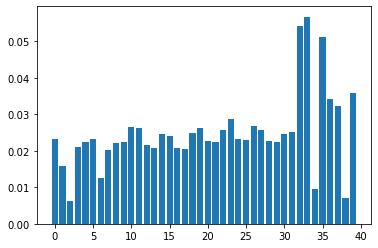

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

merge_df = merged_df.copy()

X = merge_df.drop(columns=['label'])
y = merge_df['label']

# define the model
model = RandomForestClassifier(random_state=42)
# fit the model
pipeline = Pipeline([('StandardScaler', StandardScaler()),('RFC', model)])
pipeline.fit(X, y)
# get importance
importance = model.feature_importances_
feature, score = [], []

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    feature.append(i)
    score.append(v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [32]:
data = {'feature': feature, 'score': score}
sortImpt = pd.DataFrame(columns=['feature', 'score'], data=data)

In [38]:
sortImpt.sort_values(by=['score'], ascending=False)

,feature,score
33,33,0.056753
32,32,0.054078
35,35,0.051247
39,39,0.035845
36,36,0.034196
37,37,0.032248
23,23,0.028663
26,26,0.026883
10,10,0.026525
11,11,0.026324


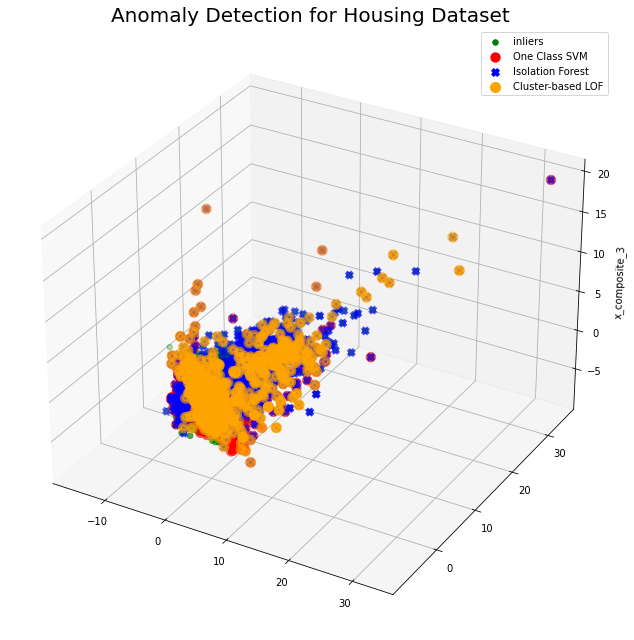

In [10]:
merge_df = merged_df.copy()

# Outlier Detection
classifier_dict = {"One-Class SVM": OneClassSVM(nu=0.05),
                   "Isolation Forest": IsolationForest(contamination=0.05),
                   "Cluster-based LOF": LocalOutlierFactor(contamination=0.05)}
Outliers = pd.DataFrame()
for i, (clf_name, clf) in enumerate(classifier_dict.items()):
    clf.fit(merge_df)
    merge_df["anomaly"] = clf.fit_predict(merge_df)
    outliers_subset = merge_df[merge_df.anomaly == -1]
    outliers_subset = outliers_subset.assign(model = clf_name)
    Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=False)

pca = PCA(n_components=3) # reduce to k=3 dimensions
scaler = StandardScaler()
X = scaler.fit_transform(merged_df)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection="3d")
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=30, lw=1, label="inliers",c="green")
ax.scatter(X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 0],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 1],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 2],
           lw=4, s=40, c="red", label="One Class SVM")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 2],
           lw=4, s=40, marker='x', c="blue", label="Isolation Forest")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 2],
           lw=4, s=50, c="orange", label="Cluster-based LOF")
plt.title("Anomaly Detection for Housing Dataset", fontsize=20)
plt.legend()
plt.tight_layout()

## Isolation Forest Model

Initial shape of the training dataset (13399, 40) (13399,)
Shape of the training dataset after removing outliers (12059, 40) (12059,)
*********** Isolation Forest MAPE: 73906803843602208.00% *************


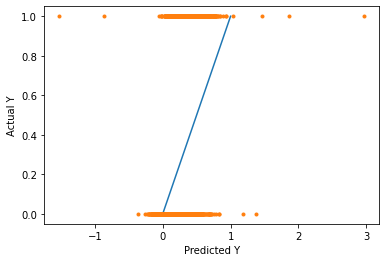

In [11]:
# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
x_out = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
mape = mean_absolute_percentage_error(y_test, yhat1)
print(f'*********** Isolation Forest MAPE: {mape*100:.2f}% *************')

plt.plot(y_test, y_test)  # baseline
plt.plot(yhat1, y_test, '.')  # actual vs. prediction
plt.xlabel('Predicted Y')
plt.ylabel('Actual Y')
plt.show()

## Local Outlier Factor Model

Initial shape of the training dataset (13399, 40) (13399,)
Shape of the training dataset after removing outliers (12059, 40) (12059,)
*********** Isolation Forest MAPE: 72862518904362032.00% *************


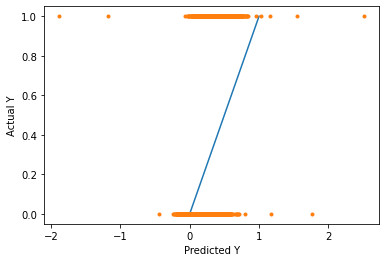

In [12]:
# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
x_out = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
mape = mean_absolute_percentage_error(y_test, yhat1)
print(f'*********** Isolation Forest MAPE: {mape*100:.2f}% *************')

plt.plot(y_test, y_test)  # baseline
plt.plot(yhat1, y_test, '.')  # actual vs. prediction
plt.xlabel('Predicted Y')
plt.ylabel('Actual Y')
plt.show()

## One-Class SVM Model

Initial shape of the training dataset (13399, 40) (13399,)
Shape of the training dataset after removing outliers (12058, 40) (12058,)
********** One-class SVM MAPE: 74472782657553184.00% **********


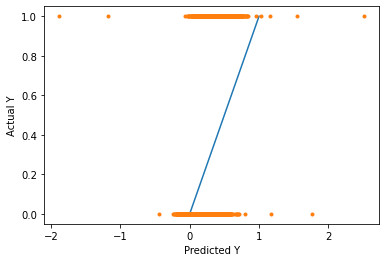

In [13]:
# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
# identify outliers in the training dataset
svm = OneClassSVM(nu=0.1)
x_out = svm.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat4 = model.predict(X_test)
# evaluate predictions
mape = mean_absolute_percentage_error(y_test, yhat4)
print(f'********** One-class SVM MAPE: {mape*100:.2f}% **********')

plt.plot(y_test, y_test)  # baseline
plt.plot(yhat1, y_test, '.')  # actual vs. prediction
plt.xlabel('Predicted Y')
plt.ylabel('Actual Y')
plt.show()

## Handling Imbalanced Data

zeros:  15007
ones:  4992


([<matplotlib.patches.Wedge at 0x23601f207f0>,
 [Text(-0.7787637472368022, 0.7768700187223692, 'zeros'),
  Text(0.7787636745009786, -0.7768700916354897, 'ones')],
 [Text(-0.42478022576552843, 0.42374728293947406, '75.0%'),
  Text(0.4247801860914428, -0.42374732271026705, '25.0%')])

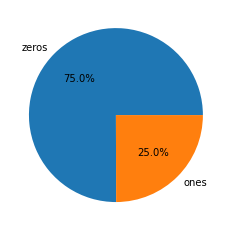

In [14]:
labels = merged_df['label']
labels = np.array(labels)
zeros, ones = 0, 0
for i in range(len(labels)):
    if labels[i] == 0:
        zeros += 1
    else:
        ones += 1
        
print('zeros: ', str(zeros))
print('ones: ', str(ones))

plt.pie([zeros, ones], labels=['zeros', 'ones'], autopct='%1.1f%%')

## Random Under Sampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.75, random_state=102)
# define model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.65      0.67      0.66      1263
     class 1       0.65      0.63      0.64      1233

    accuracy                           0.65      2496
   macro avg       0.65      0.65      0.65      2496
weighted avg       0.65      0.65      0.65      2496



## Random Over Sampling

In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, train_size=0.75, random_state=102)
# define model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.64      0.67      0.65      3751
     class 1       0.65      0.63      0.64      3753

    accuracy                           0.65      7504
   macro avg       0.65      0.65      0.65      7504
weighted avg       0.65      0.65      0.65      7504



## Synthetic Minority Over-Sampling Technique (SMOTE)

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=0.75, random_state=102)
# define model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.63      0.66      0.64      3751
     class 1       0.64      0.61      0.63      3753

    accuracy                           0.63      7504
   macro avg       0.63      0.63      0.63      7504
weighted avg       0.63      0.63      0.63      7504



## XGBoost

In [18]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=102)
# define model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
# make prediction
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.79      0.93      0.85      3740
     class 1       0.53      0.25      0.34      1260

    accuracy                           0.76      5000
   macro avg       0.66      0.59      0.60      5000
weighted avg       0.72      0.76      0.72      5000

